<a href="https://colab.research.google.com/github/khadijaSukola/COVID-19-Prediction/blob/main/KhadijaMuktarSukola_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3MTT CAPSTONE PROJECT**

Project Topic: Predictive Modelling for COVID-19 in Public Health

Dataset used: Kaggle covid 19 (Worldometer_data)

Name: Khadija Muktar Sukola

Fellow ID: FE/23/82197244

Track: Data science

Date: November, 2024

Importing all the necessary Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

Step 1: Load the Dataset

In [2]:
file_path = '/content/worldometer_data.csv'
data = pd.read_csv(file_path)

Step 2: Data Cleaning

In [3]:
# Standardizing column names
data.columns = data.columns.str.replace(r'[^\w\s]', '').str.replace(' ', '_').str.strip()

# Handling missing values

# Numerical: Fill with median
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# Categorical: Fill with mode
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])


Step 3: Exploratory Data Analysis (EDA)

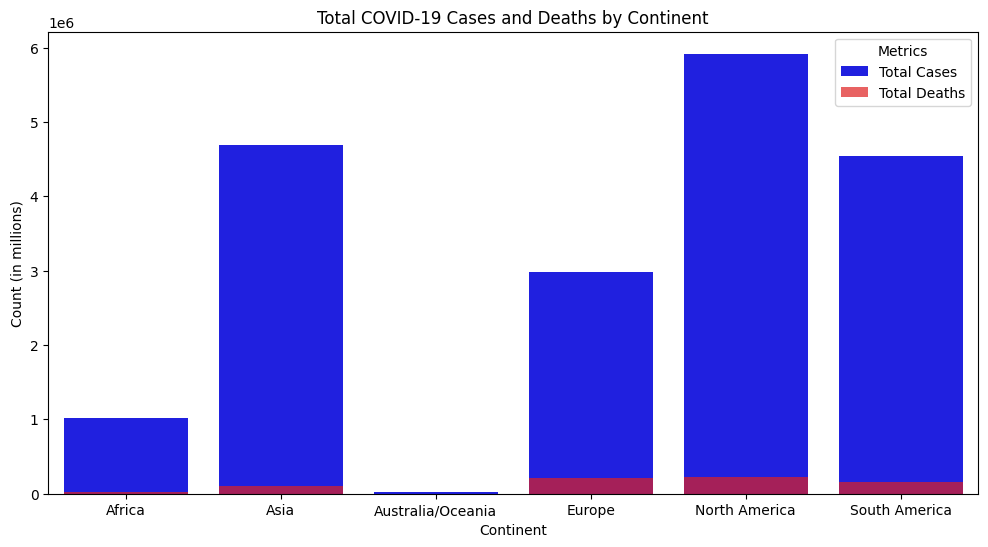

In [4]:
# Ploting total cases and deaths by continent
continent_summary = data.groupby('Continent')[['TotalCases', 'TotalDeaths', 'TotalRecovered']].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Continent', y='TotalCases', data=continent_summary, color='blue', label='Total Cases')
sns.barplot(x='Continent', y='TotalDeaths', data=continent_summary, color='red', label='Total Deaths', alpha=0.7)
plt.title('Total COVID-19 Cases and Deaths by Continent')
plt.ylabel('Count (in millions)')
plt.xlabel('Continent')
plt.legend(title='Metrics')
plt.show()

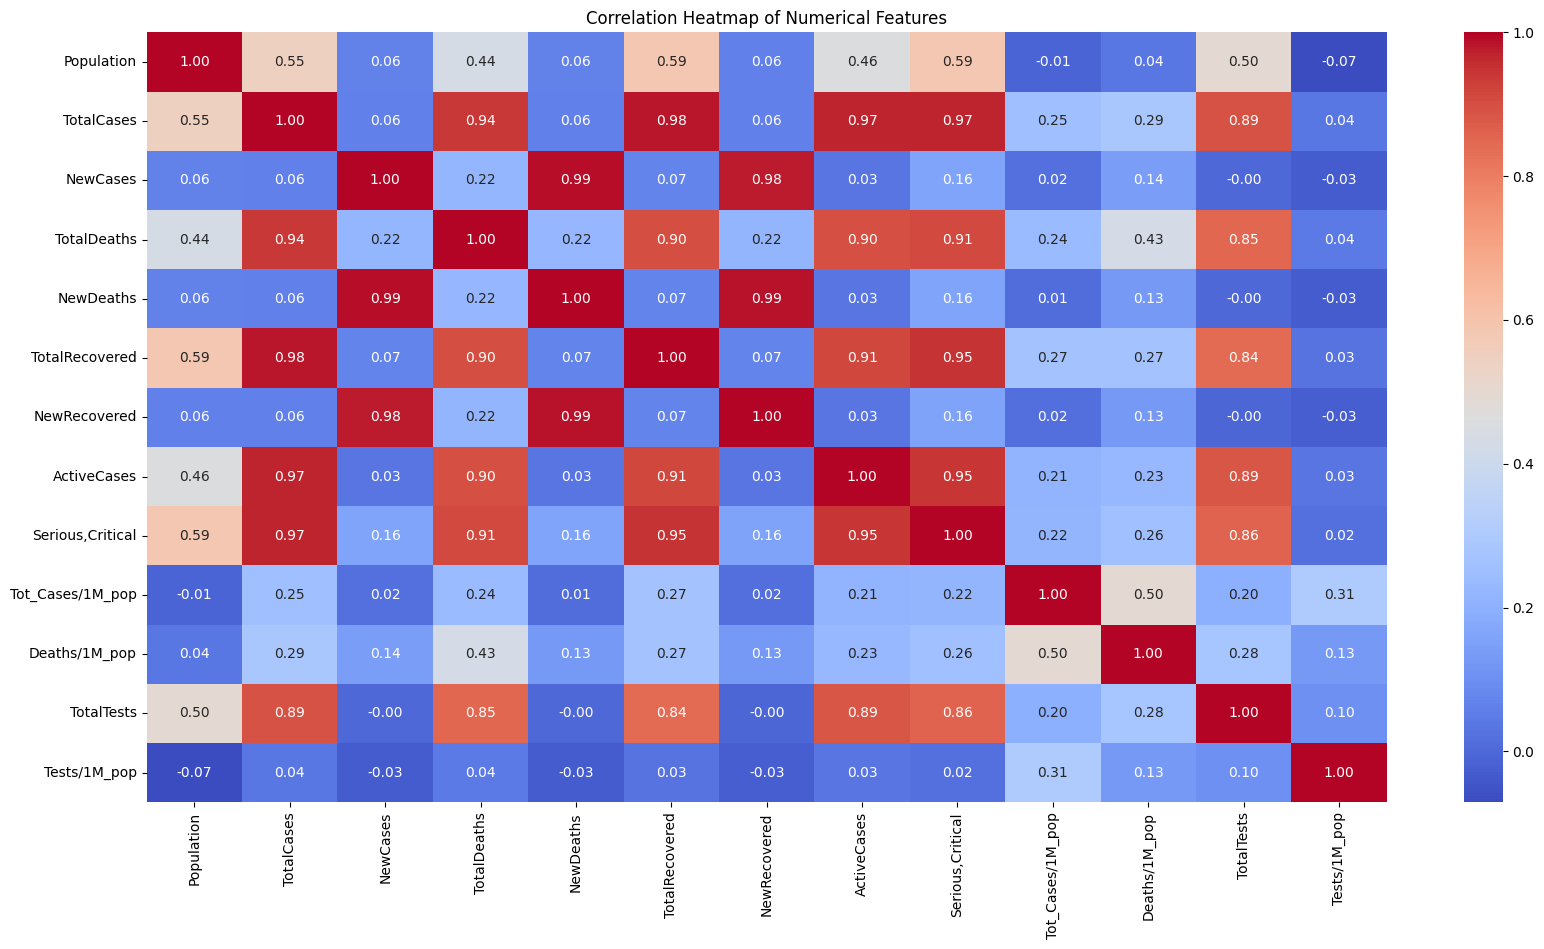

In [5]:
# Select only numerical columns for the correlation heatmap
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


Step 4: Feature Engineering

In [6]:
# Calculate mortality ratio
data['MortalityRatio'] = (data['TotalDeaths'] / data['TotalCases']) * 100

# Recovery Ratio: TotalRecovered / TotalCases
data['RecoveryRatio'] = (data['TotalRecovered'] / data['TotalCases']) * 100

# Cases per Population: TotalCases / Population
data['CasesPerPopulation'] = data['TotalCases'] / data['Population']

# Deaths per 1M Population: Deaths / Population * 1,000,000
data['DeathsPer1M'] = (data['TotalDeaths'] / data['Population']) * 1_000_000

# Cases per 1M Population: TotalCases / Population * 1,000,000
data['CasesPer1M'] = (data['TotalCases'] / data['Population']) * 1_000_000

In [7]:
# Calculate Daily Growth Rate for Cases, Deaths, and Recoveries

data['DailyGrowthRateCases'] = (data['NewCases'] / data['TotalCases']) * 100
data['DailyGrowthRateDeaths'] = (data['NewDeaths'] / data['TotalDeaths']) * 100
data['DailyGrowthRateRecovered'] = (data['NewRecovered'] / data['TotalRecovered']) * 100

# Applying a rolling window to calculate the moving average for growth rate,
#to smooth out volatility across daily fluctuations:
# calculating 7-day moving average for growth rates
data['DailyGrowthRateCases_MA7'] = data['DailyGrowthRateCases'].rolling(window=7).mean()
data['DailyGrowthRateDeaths_MA7'] = data['DailyGrowthRateDeaths'].rolling(window=7).mean()
data['DailyGrowthRateRecovered_MA7'] = data['DailyGrowthRateRecovered'].rolling(window=7).mean()

# Cleaning up any NaN values generated by rolling means (if any)
data.fillna(0, inplace=True)

# Print the updated dataframe with new columns
print(data[['Country/Region', 'MortalityRatio', 'RecoveryRatio', 'CasesPerPopulation',
            'DeathsPer1M', 'CasesPer1M', 'DailyGrowthRateCases', 'DailyGrowthRateDeaths',
            'DailyGrowthRateRecovered', 'DailyGrowthRateCases_MA7',
            'DailyGrowthRateDeaths_MA7', 'DailyGrowthRateRecovered_MA7']].head())

  Country/Region  MortalityRatio  RecoveryRatio  CasesPerPopulation  \
0            USA        3.235259      51.203822            0.015194   
1         Brazil        3.381042      70.183941            0.013716   
2          India        2.055782      68.005228            0.001466   
3         Russia        1.675204      77.573306            0.005974   
4   South Africa        1.784520      71.967208            0.009063   

   DeathsPer1M    CasesPer1M  DailyGrowthRateCases  DailyGrowthRateDeaths  \
0   491.560746  15193.862961              0.013036               0.049139   
1   463.747257  13716.104125              0.022485               0.081100   
2    30.143085   1466.258613              0.032389               0.192132   
3   100.081592   5974.294092              0.075239               0.547720   
4   161.733694   9063.149328              0.121891               0.832986   

   DailyGrowthRateRecovered  DailyGrowthRateCases_MA7  \
0                  0.036326                       0.0

In [8]:
# Function to create a bar plot

def plot_top_countries(data, column, title):
    # Sort data by the specified column in descending order and select top 10
    top_data = data.sort_values(by=column, ascending=False).head(10)

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_data,
        x="Country/Region",
        y=column,
        color="blue"
    )

    plt.title(title, fontsize=16)
    plt.xlabel("Country/Region", fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()



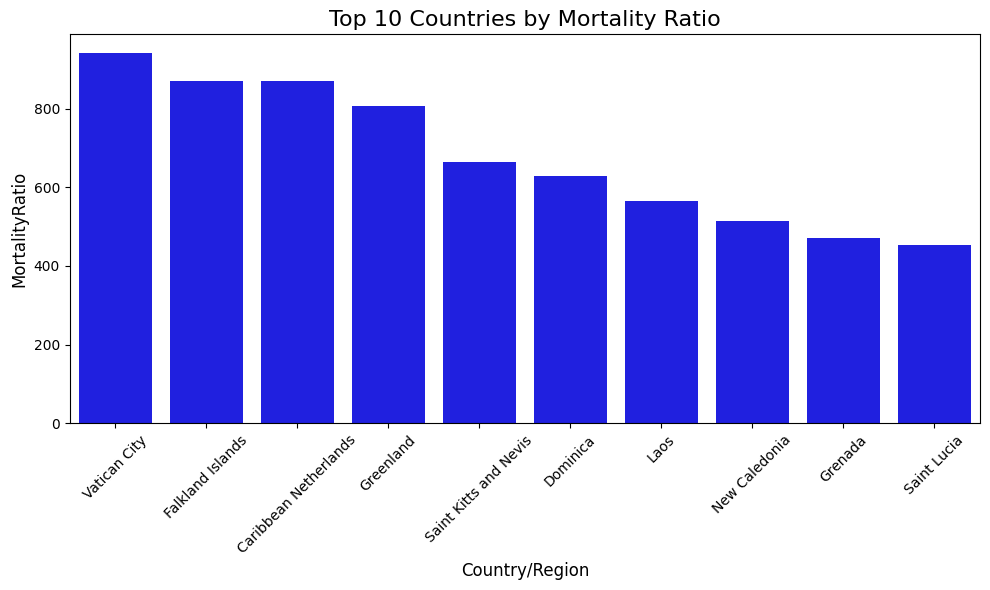

In [9]:
# Plot Mortality Ratio
plot_top_countries(data, column="MortalityRatio", title="Top 10 Countries by Mortality Ratio") #, ylabel="Mortality Ratio (%)")



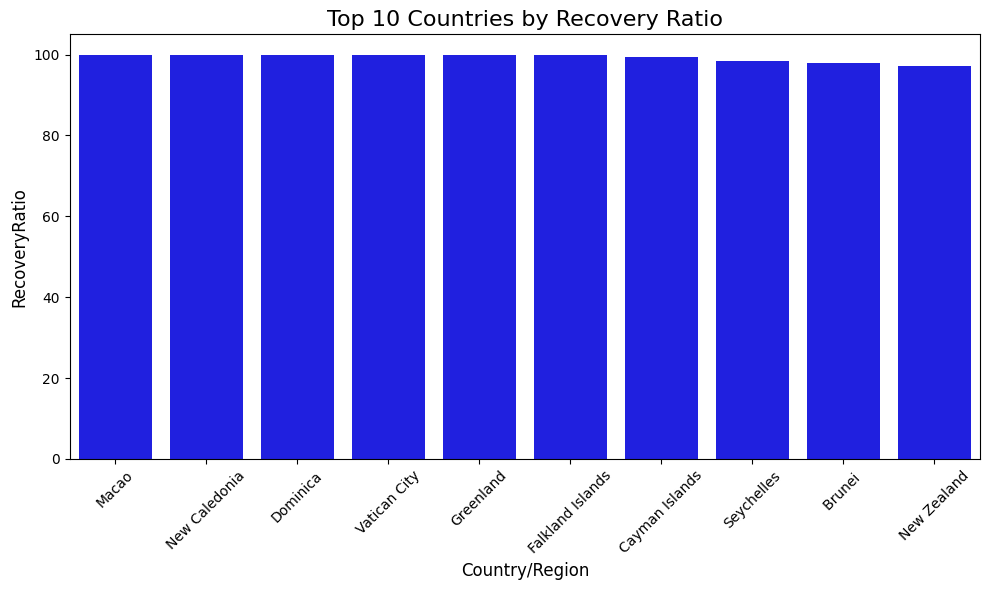

In [10]:
# Plot Recovery Ratio
plot_top_countries(data, column="RecoveryRatio", title="Top 10 Countries by Recovery Ratio") #, ylabel="Recovery Ratio (%)")



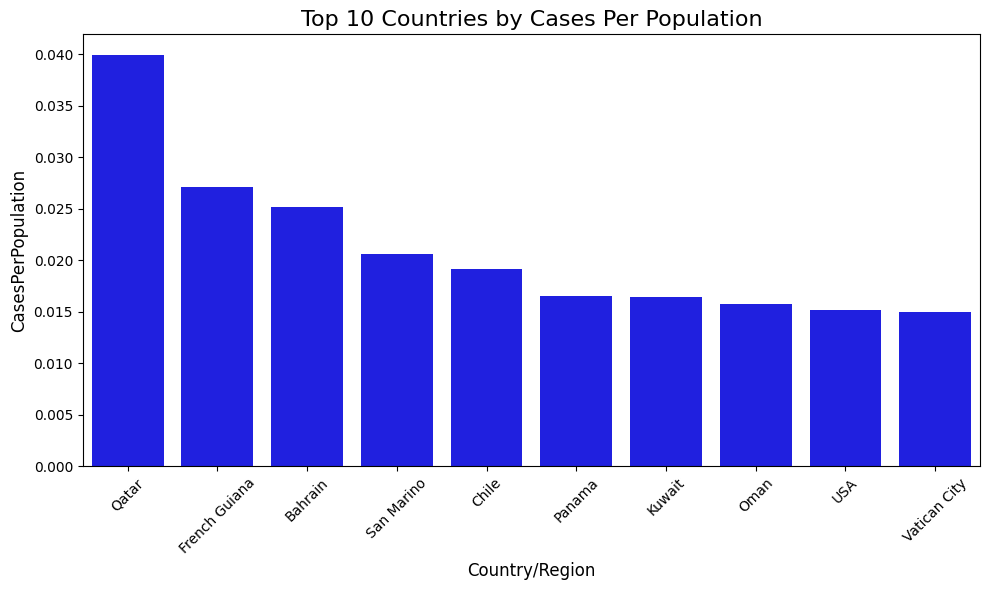

In [11]:
# Plot Cases Per Population
plot_top_countries(data, column="CasesPerPopulation", title="Top 10 Countries by Cases Per Population") #, ylabel="Cases Per Population")



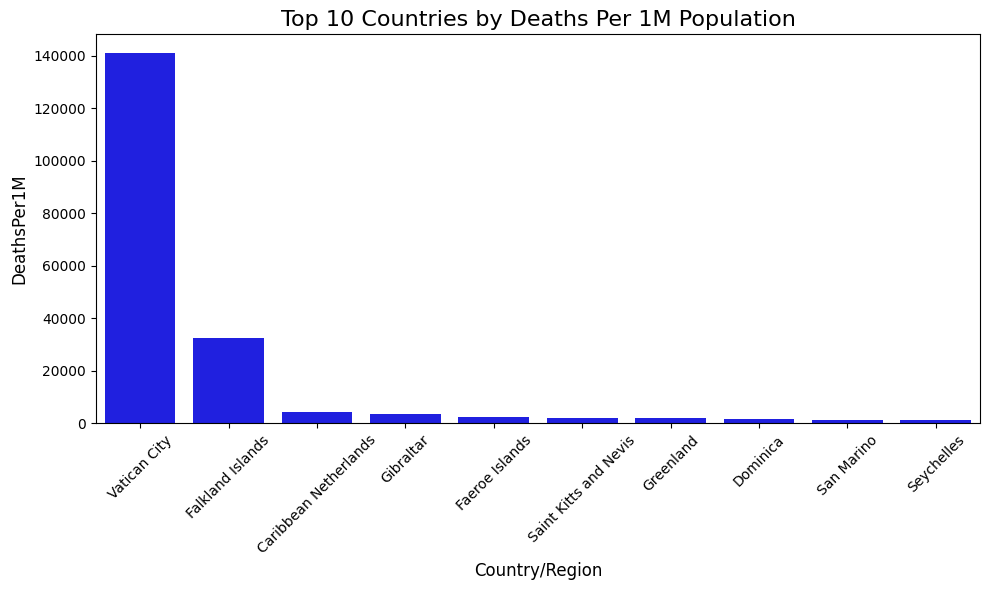

In [12]:
# Plot Deaths Per 1M Population
plot_top_countries(data, column="DeathsPer1M", title="Top 10 Countries by Deaths Per 1M Population") #, ylabel="Deaths Per Million")



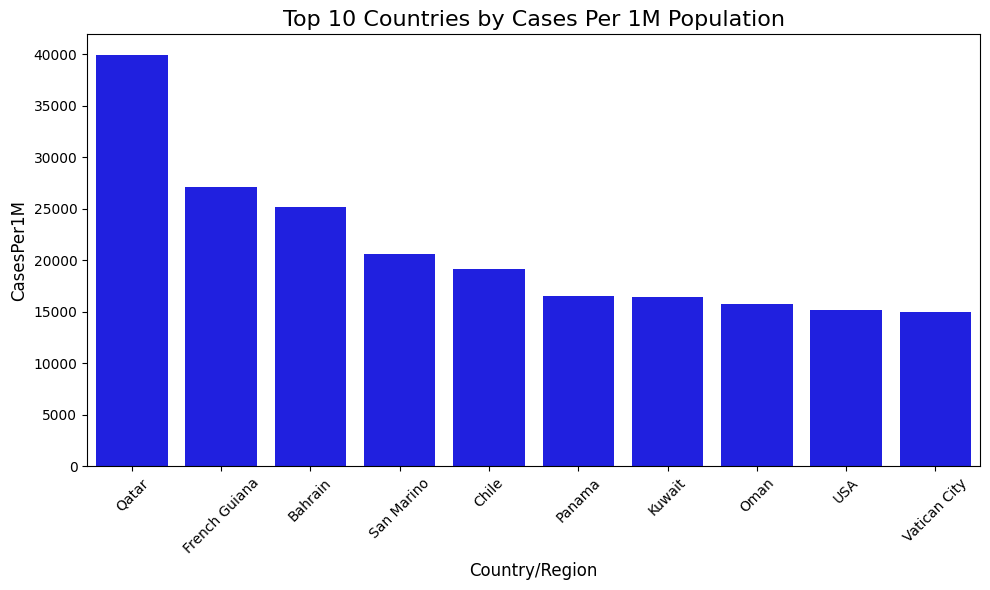

In [13]:
# Plot Cases Per 1M Population
plot_top_countries(data, column="CasesPer1M", title="Top 10 Countries by Cases Per 1M Population") #, ylabel="Cases Per Million")



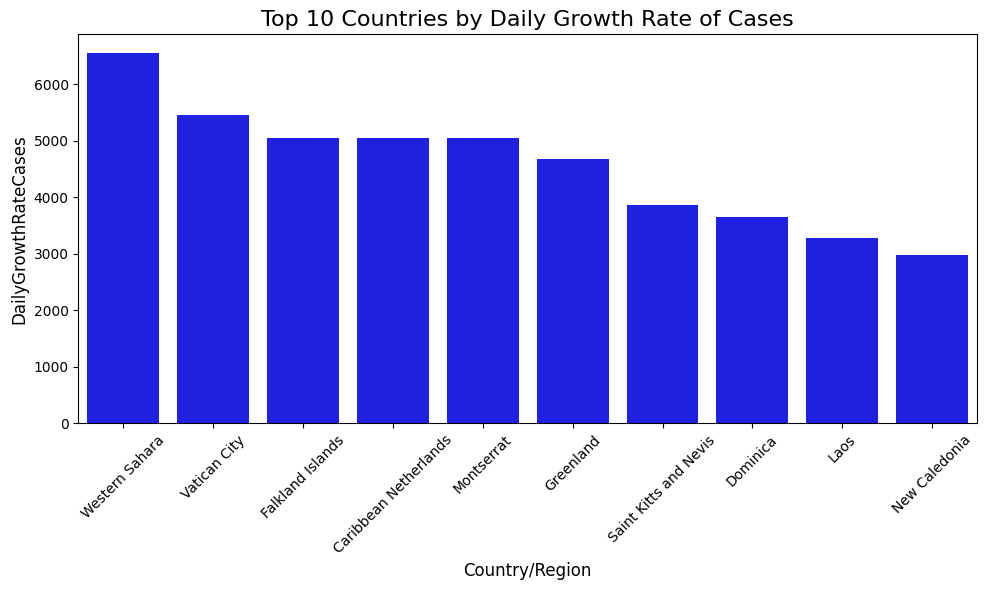

In [14]:
# Plot DailyGrowthRateCases
plot_top_countries(data, column="DailyGrowthRateCases", title="Top 10 Countries by Daily Growth Rate of Cases")


In [15]:
# Top 10 countries by Total Cases
top_10_countries = data.nlargest(10, 'TotalCases')['Country/Region']

# Filter dataset for top 10 countries and Create a copy of the filtered data
filtered_data = data[data['Country/Region'].isin(top_10_countries)].copy()

# Adding a "Day Index" for progression
filtered_data['Day Index'] = filtered_data.groupby('Country/Region').cumcount() + 1

# Plot function
def plot_line(data, column, title, ylabel):
    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=data,
        x="Day Index",
        y=column,
        hue="Country/Region",
        marker="o"
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Day Index", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title="Country/Region", fontsize=10)
    plt.tight_layout()
    plt.show()



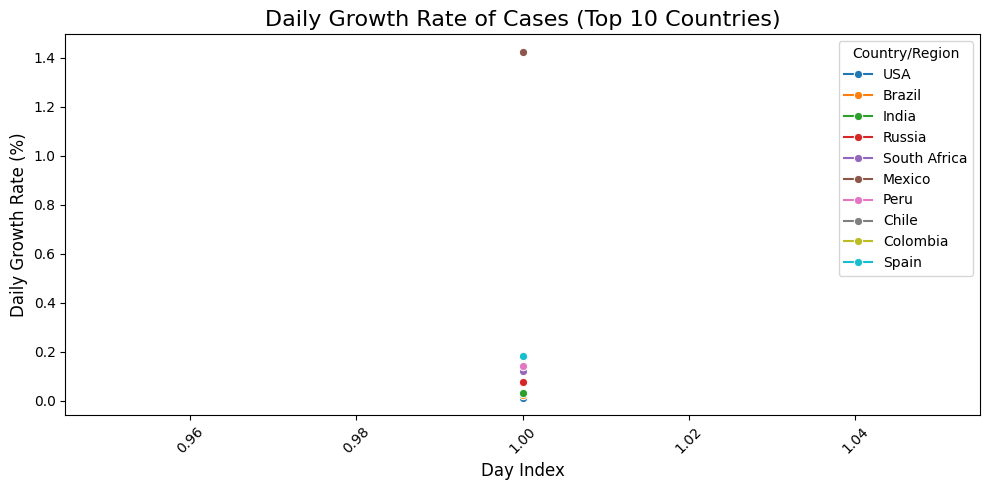

In [16]:
# Plot Daily Growth Rates for Cases
plot_line(
    data=filtered_data,
    column="DailyGrowthRateCases",
    title="Daily Growth Rate of Cases (Top 10 Countries)",
    ylabel="Daily Growth Rate (%)"
)



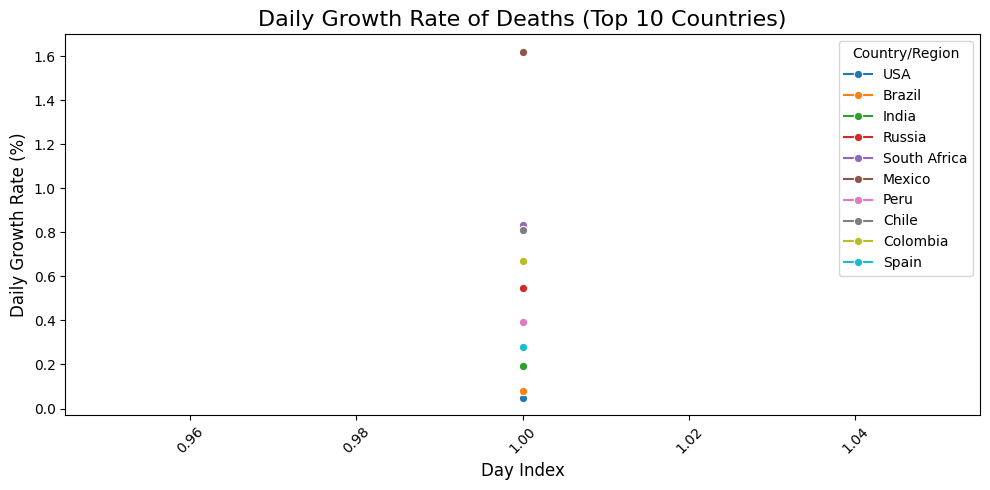

In [17]:
# Plot Daily Growth Rates for Deaths
plot_line(
    data=filtered_data,
    column="DailyGrowthRateDeaths",
    title="Daily Growth Rate of Deaths (Top 10 Countries)",
    ylabel="Daily Growth Rate (%)"
)


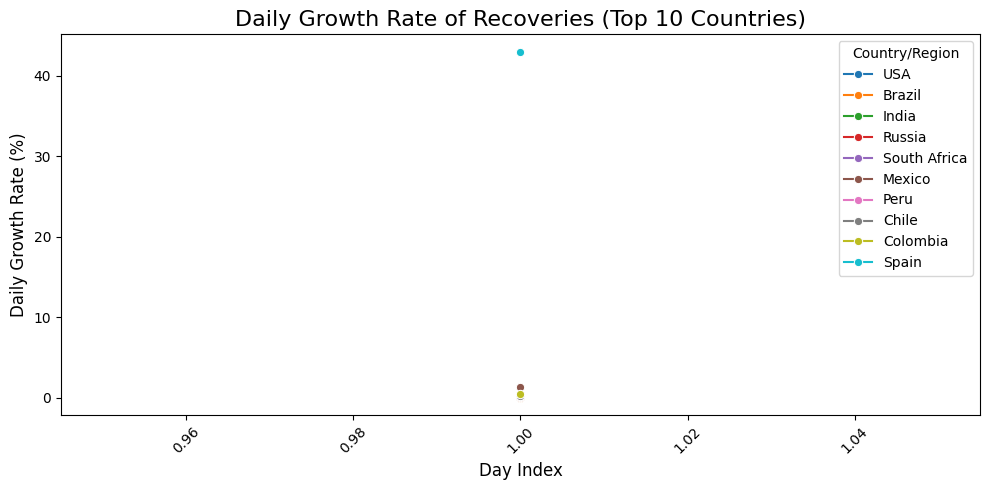

In [18]:
# Plot Daily Growth Rates for Recovered
plot_line(
    data=filtered_data,
    column="DailyGrowthRateRecovered",
    title="Daily Growth Rate of Recoveries (Top 10 Countries)",
    ylabel="Daily Growth Rate (%)"
)

Step 5: Predictive Modeling

In [19]:

features = ['Population', 'TotalDeaths', 'TotalRecovered', 'ActiveCases', 'MortalityRatio', 'RecoveryRatio',
            'CasesPerPopulation', 'DeathsPer1M', 'CasesPer1M', 'DailyGrowthRateCases_MA7', 'DailyGrowthRateDeaths_MA7']
target =  'TotalCases'

X = data[features]
y = data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

from sklearn.model_selection import GridSearchCV
param_grid = {
   'n_estimators': [50, 100, 150],
   'max_depth': [None, 10, 20],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")


from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validated RMSE: {np.sqrt(-cv_scores.mean())}")


print(f"Model RMSE: {rmse}")
print(f"Model R2 Score: {r2}")
print(f"Model Accuracy: {r2 * 100:.2f}%")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-validated RMSE: 431147.8718347476
Model RMSE: 8936.735059759292
Model R2 Score: 0.9871246545681115
Model Accuracy: 98.71%


Step 6: Visualization of Predictions

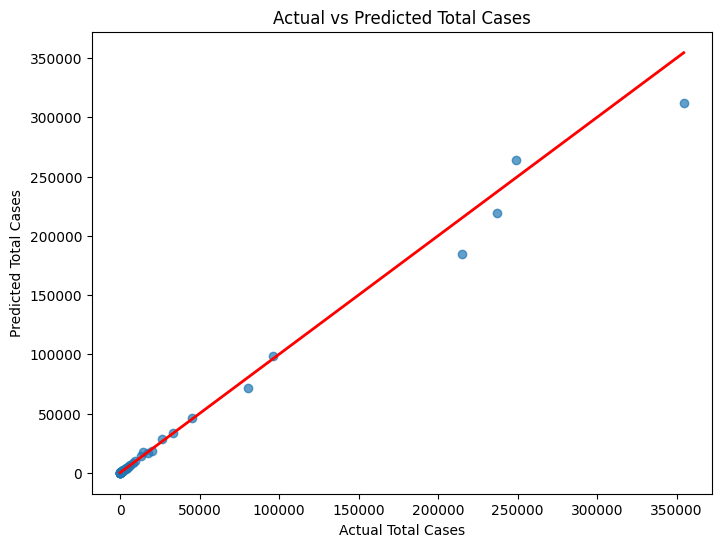

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title("Actual vs Predicted Total Cases")
plt.xlabel("Actual Total Cases")
plt.ylabel("Predicted Total Cases")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.show()

Step 7: Save Results

In [21]:
# Save cleaned data and model predictions
from google.colab import files
import joblib
data.to_csv('cleaned_covid_data.csv', index=False)
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.to_csv('predictions.csv', index=False)
joblib.dump(model, 'covid_model.pkl')

files.download('cleaned_covid_data.csv')
files.download('predictions.csv')
files.download('covid_model.pkl')

['covid_model.pkl']